In [1]:
%pwd

'/Users/erinhansen/Documents/DSE/capstone/DataExploration/Financial-Modeling'

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

import clustering

In [3]:
# df1 = pd.read_csv('../../../sample_2000_M5_social2.csv')
# df2 = pd.read_csv('../../../sample_data_2017_M4_v3.csv', 
#                  dtype= {'FormationYr':'object'},
#                  low_memory=False)
# df_original = df1[['EIN']].merge(df2, on = 'EIN', how = 'inner')

In [4]:
'''
Read, clean, and separate data by form type.
'''
df_original = pd.read_csv('../../../capstone-data/sample_data_2017_M4_v3.csv', 
                 dtype= {'FormationYr':'object'},
                 low_memory=False)
df_original = df_original.drop(['ActivityOrMissionDesc'
              , 'BooksInCareOfDetail/USAddress/ZIPCode'
              , 'PrincipalOfficerNm'
              , 'Desc'
              , 'MissionDesc'
              , 'PrimaryExemptPurposeTxt'
              , 'OrganizationName'
              , 'URL'
              , 'WebsiteAddressTxt'
              , '_id'
              , 'TaxExemptBondsInd'
              , 'NoListedPersonsCompensatedInd'
              , 'TaxPeriod'
             ], axis =1)

df_990 = df_original[df_original['FormType'] == '990']
df_990 = df_990.drop(['FormType'], axis = 1)
df_990 = df_990.fillna(0)
df_990.reset_index(inplace=True, drop = True)

df_990EZ = df_original[df_original['FormType'] == '990EZ']
df_990EZ = df_990EZ.drop(['FormType'], axis = 1)
df_990EZ = df_990EZ.dropna(how = "all", axis = 1)
df_990EZ = df_990EZ.fillna(0)
df_990EZ.reset_index(inplace=True, drop = True)

### Form 990 Modeling

In [5]:
'''
Data prep & feature engineering
'''

# Functions for cleaning
def replace_infinity(result):
    result = result.fillna(0)
    result = result.replace(np.inf, 1.0)
    result = result.replace(-np.inf, 0.0)
    return result

def calculatePercentChange(series1, series2):
    result = (series1-series2)/series1
    return replace_infinity(result)

def scaleColumns(df, cols_to_scale, scaler):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df



# Transform ScheduleB required boolean column to binary
df_990['ScheduleBRequiredInd'] = df_990['ScheduleBRequiredInd'].replace('false', 0).replace('true', 1).replace('0', 0).replace('1', 1).astype('int64')

# Transform formation year into age calcualtion
df_990['FormationYr'] = df_990['FormationYr'].astype('int64')
now = datetime.now()

# Age is current year minus formation year, else 0
df_990['FilerAge'] = df_990['FormationYr'].apply(lambda x: now.year-x if x != 0 else 0)

# TotalContributionsAmt divided by RevenueAmt
df_990['TotalContribRatio'] = df_990['TotalContributionsAmt']/df_990['RevenueAmt']
df_990['TotalContribRatio'] = replace_infinity(df_990['TotalContribRatio'])

# ProgramServicesAmt divided by TotalAmt
df_990['ProgramServicesRatio'] = df_990['TotalFunctionalExpensesGrp/ProgramServicesAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['ProgramServicesRatio'] = replace_infinity(df_990['ProgramServicesRatio'])

# ProgramServicesAmt divided by TotalAmt
df_990['ManagementExpRatio'] = df_990['TotalFunctionalExpensesGrp/ManagementAndGeneralAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['ManagementExpRatio'] = replace_infinity(df_990['ManagementExpRatio'])

# ProgramServicesAmt divided by TotalAmt
df_990['FundraisingRatio'] = df_990['TotalFunctionalExpensesGrp/FundraisingAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['FundraisingRatio'] = replace_infinity(df_990['FundraisingRatio'])

# % Change of Assets over the year
df_990['PercentTotalAsstChng'] = calculatePercentChange(df_990['TotalAssetsGrp/BOYAmt'], df_990['TotalAssetsGrp/EOYAmt'])
df_990['PercentFundBalChng'] = calculatePercentChange(df_990['TotLiabNetAssetsFundBalanceGrp/BOYAmt'], df_990['TotLiabNetAssetsFundBalanceGrp/EOYAmt'])
df_990['PercentTotalLiabChng'] = calculatePercentChange(df_990['TotalLiabilitiesGrp/BOYAmt'], df_990['TotalLiabilitiesGrp/EOYAmt'])

# Drop Columns!
df_990 = df_990.drop(columns=['FormationYr',
                      'TotalContributionsAmt',
                      'TotalFunctionalExpensesGrp/ProgramServicesAmt',
                      'TotalFunctionalExpensesGrp/ManagementAndGeneralAmt',
                      'TotalFunctionalExpensesGrp/FundraisingAmt',
                      'TotalAssetsGrp/BOYAmt',
                      'TotLiabNetAssetsFundBalanceGrp/BOYAmt',
                      'TotalLiabilitiesGrp/BOYAmt'
                     ])

# Scale columns where it makes sense to
cols = df_990.columns
set_cols = set(cols)
cols_not_scale = ['EIN', 
                  'FilerAge',
                  'TotalContribRatio',
                  'FundraisingRatio',
                  'ManagementExpRatio',
                  'PercentFundBalChng',
                  'PercentTotalAsstChng',
                  'PercentTotalLiabChng'
                 ]

for col in cols_not_scale:
    set_cols.remove(col)
    
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()

df_990 = scaleColumns(df_990, list(set_cols), min_max_scaler)

[0.73002145 0.99911493 0.999932   0.99999997 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


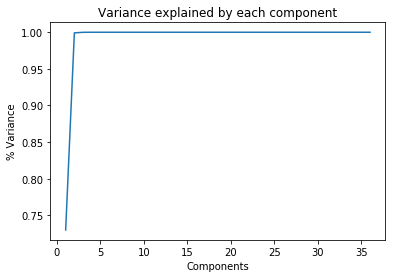

In [6]:
'''
Dimensionality reduction with PCA
'''

# Helper functions
def PCA_components(df):
    pca = PCA()
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    var = pca.explained_variance_ratio_
    var_cumsum = np.cumsum(var)
    comp = range(1, len(var)+1)

    %matplotlib inline
    plt.plot(comp,var_cumsum)
    plt.xlabel('Components')
    plt.ylabel('% Variance')
    plt.title('Variance explained by each component')
    print(var_cumsum)

def fit_pca(df, n):
    eins = list(df['EIN'])
    pca = PCA(n_components = n)
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    df_pca = pd.DataFrame(df_pca)
    df_pca['EIN'] = eins
    return df_pca

PCA_components(df_990)
df_990_reduced = fit_pca(df_990, 2)

In [7]:
'''
Hierarchical clustering using clustering.py script
'''
X = df_990_reduced.loc[:, df_990_reduced.columns != 'EIN'].values

'''
Z is linkage matrix
gap_metrics is dictionary of ks, logWs, logBWs, and stderr values
bc is best number of clusters
clusters are labels
'''
Z, gap_metrics, bc, clusters_990 = clustering.create_clusters(X, C = 500)

df_990['labels'] = clusters_990
# df_990.groupby(['labels']).count()['EIN']

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100
Scanning: 110
Scanning: 120
Scanning: 130
Scanning: 140
Scanning: 150
Scanning: 160
Scanning: 170
Scanning: 180
Scanning: 190
Scanning: 200
Scanning: 210
Scanning: 220
Scanning: 230
Scanning: 240
Scanning: 250
Scanning: 260
Scanning: 270
Scanning: 280
Scanning: 290
Scanning: 300
Scanning: 310
Scanning: 320
Scanning: 330
Scanning: 340
Scanning: 350
Scanning: 360
Scanning: 370
Scanning: 380
Scanning: 390
Scanning: 400
Scanning: 410
Scanning: 420
Scanning: 430
Scanning: 440
Scanning: 450
Scanning: 460
Scanning: 470
Scanning: 480
Scanning: 490
Scanning: 500

Cluster sizes: [350 354 374 375 378 395 400 401 412 417 421 423 425 427 430 432 438 445
 448 450 454 456 459 462 464 466 469 472 476 479 481 484 485 494 499]


### Form 990EZ Modeling

In [8]:
'''
Data prep & feature engineering
'''
# Coalesce net assets columns
net_assets = []
for i in df_990EZ.index:
    if df_990EZ.loc[i, 'NetAssetsOrFundBalancesGrp/EOYAmt'] == 0:
        net_assets.append(df_990EZ.loc[i,'NetAssetsOrFundBalancesEOYAmt'])
    else:
        net_assets.append(df_990EZ.loc[i,'NetAssetsOrFundBalancesGrp/EOYAmt'])
df_990EZ['NetAssets'] = net_assets

df_990EZ.drop(['NetAssetsOrFundBalancesGrp/EOYAmt', 'NetAssetsOrFundBalancesEOYAmt'], axis=1, inplace=True)

# Scale columns where it makes sense to
cols = df_990EZ.columns
set_cols = set(cols)
cols_not_scale = ['EIN']

for col in cols_not_scale:
    set_cols.remove(col)
    
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()

df_990EZ = scaleColumns(df_990EZ, list(set_cols), scaler)

In [9]:
'''
Hierarchical clustering using clustering.py script
'''
X = df_990EZ.loc[:, df_990EZ.columns != 'EIN'].values

'''
Z is linkage matrix
gap_metrics is dictionary of ks, logWs, logBWs, and stderr values
bc is best number of clusters
clusters are labels
'''
Z, gap_metrics, bc, clusters_990EZ = clustering.create_clusters(X, C = 500)

df_990EZ['labels'] = clusters_990EZ
df_990EZ.groupby(['labels']).count()['EIN']

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100
Scanning: 110
Scanning: 120
Scanning: 130
Scanning: 140
Scanning: 150
Scanning: 160
Scanning: 170
Scanning: 180
Scanning: 190
Scanning: 200
Scanning: 210
Scanning: 220
Scanning: 230
Scanning: 240
Scanning: 250
Scanning: 260
Scanning: 270
Scanning: 280
Scanning: 290
Scanning: 300
Scanning: 310
Scanning: 320
Scanning: 330
Scanning: 340
Scanning: 350
Scanning: 360
Scanning: 370
Scanning: 380
Scanning: 390
Scanning: 400
Scanning: 410
Scanning: 420
Scanning: 430
Scanning: 440
Scanning: 450
Scanning: 460
Scanning: 470
Scanning: 480
Scanning: 490
Scanning: 500

Cluster sizes: [ 83  85  86  99 100 109 113 116 117 119 120 121 123 124 126 127 128 129
 131 133 134 136 140 141 145 147 148 149 151 152 154 155 157 158 160 162
 164 166 169 171 172 174 175 177 178 179 181 182 183 185 187 188 189 190
 191 192 193 194 195 196 198 199 203 204 205 207 208 209 211 212 213 215
 

labels
1        2
2      282
3      389
4      164
5      154
6      299
7      106
8      175
9      935
10     568
11     497
12     249
13     355
14     511
15     362
16     295
17     225
18     568
19     786
20     314
21     923
22     468
23     514
24       2
25       5
26       1
27    1533
28     913
29     384
30      13
      ... 
54      14
55     158
56     123
57      40
58     151
59     198
60      91
61      84
62      83
63     140
64     183
65      24
66      90
67     118
68     147
69      71
70     192
71     197
72     227
73      48
74     152
75     249
76      20
77      43
78      18
79      51
80      47
81     209
82     172
83     221
Name: EIN, Length: 83, dtype: int64

### Merge cluster results

In [10]:
'''
Combine original data sets and re-scale
'''

df_all = df_original[['EIN', 'GrossReceiptsAmt']]
df_all = df_all.fillna(0)
df_all = scaleColumns(df_all, ['GrossReceiptsAmt'], min_max_scaler)
df_all = df_all.merge(df_990[['EIN', 'labels']], how = 'left', on = 'EIN')
df_all = df_all.merge(df_990EZ[['EIN', 'labels']], how = 'left', on = 'EIN')
df_all = df_all.rename(index=str, columns = {'labels_x': 'labels_990', 'labels_y': 'labels_EZ'})


'''
Find the means of GrossReceiptAmt for each cluster
'''
means990 = df_all[~df_all['labels_990'].isna()]
means990 = pd.DataFrame(means990.groupby(['labels_990']).mean()['GrossReceiptsAmt'])
means990.reset_index(inplace = True)
x990 = means990.values

meansEZ = df_all[~df_all['labels_EZ'].isna()]
meansEZ = pd.DataFrame(meansEZ.groupby(['labels_EZ']).mean()['GrossReceiptsAmt'])
meansEZ.reset_index(inplace = True)
xEZ = meansEZ.values


'''
Calculate similarity scores based on cluster means 
1 row per EZ cluster, 1 col per 990 cluster
'''
similarity_scores = euclidean_distances(xEZ[:,1:], x990[:,1:])


'''
Creates column for the min sim score (i.e. closest match) and position of closest cluster
'''
min_distance = []
position = []
for row in similarity_scores:
    min_distance.append(min(row))
    position.append(min(enumerate(row),key=lambda x: x[1])[0])

meansEZ['min_distance'] = min_distance
meansEZ['position'] = position


'''
Bring in means990 data for closest cluster
'''
combined_clusters = meansEZ.merge(means990, how = 'left', left_on = 'position', right_index = True)
combined_clusters = combined_clusters.rename(index=str, columns = {'GrossReceiptsAmt_y': 'GrossReceiptsAmt_990', 'GrossReceiptsAmt_x': 'GrossReceiptsAmt_EZ'})


'''
If min distance < threshold, merge clusters, otherwise keep create new cluster
'''
threshold = .000001
new_cluster_id = max(df_990['labels'])
final_labels = []
for i in combined_clusters.index:
    if combined_clusters.loc[i, 'min_distance'] < threshold:
        final_labels.append(combined_clusters.loc[i, 'labels_990'])
    else:
        new_cluster_id += 1
        final_labels.append(new_cluster_id)
combined_clusters['final_labels'] = [int(x) for x in final_labels]
combined_clusters['labels_EZ'] = combined_clusters['labels_EZ'].astype('int64')


'''
Add final_label to df_990EZ dataframe
'''
df_990EZ = df_990EZ.merge(combined_clusters[['labels_EZ', 'final_labels']], how = 'left', left_on = 'labels', right_on = 'labels_EZ')
df_990EZ = df_990EZ.drop(['labels', 'labels_EZ'], axis = 1)
df_990EZ = df_990EZ.rename(index = str, columns = {'final_labels': 'labels'})

'''
Final dataframe with labels
'''
df_original = df_original.merge(df_990[['EIN', 'labels']], how = 'left', on = 'EIN')
df_original = df_original.merge(df_990EZ[['EIN', 'labels']], how = 'left', on = 'EIN')
df_original['labels'] = df_original['labels_x'].combine_first(df_original['labels_y'])
df_original = df_original.drop(['labels_x', 'labels_y'], axis = 1)
df_original['labels'] = df_original['labels'].astype('int64')

In [11]:
df_original.to_csv('./labels.csv', index = False)